In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble
from qiskit.compiler import transpile, assemble
from qiskit.circuit import Gate
from qiskit.circuit.library.standard_gates import *
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_city, plot_state_qsphere, array_to_latex, circuit_drawer
from qiskit.quantum_info import Statevector, random_statevector, Operator
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit.library import QFT

import matplotlib.pyplot as plt
import numpy as np
import math

Finding prime numbers has endless applications and there are many resources demonstrating how to write isPrime() functions for basic programming courses and prime detector circuits. In this project I have converted two classical prime detector circuits found online into oracles and implemented two Grover searches. The first classical circuit converted is a 4 bit able to detect the primes between 0 and 8 and the second is one able to detect prime numbers between 0 and 32. The first circuit has certain problems due to which it detects 0 and 1 as prime numbers, therefore there are 2 mcts added at the end of the oracle in order to correct this mistake. 


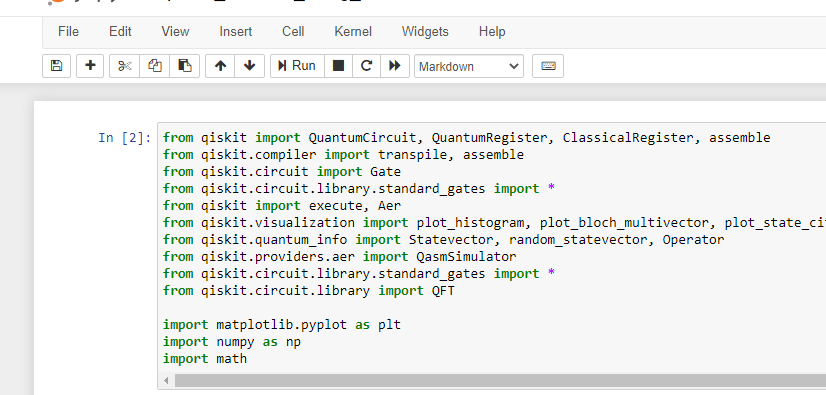

In [5]:
q = QuantumCircuit(1)
q.x(0)
X_gate = q.to_gate()
Zero_control_gate = X_gate.control(4, ctrl_state = 0)
One_control_gate = X_gate.control(4, ctrl_state = 1)

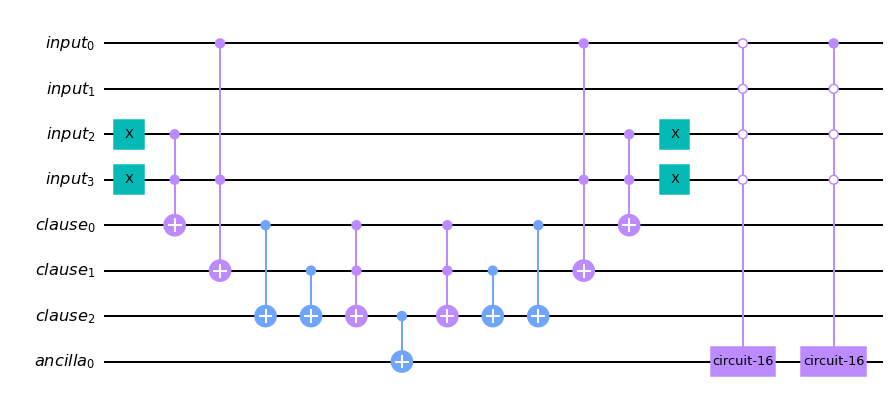

In [16]:
InputRegister = QuantumRegister(4, 'input')
ClauseRegister = QuantumRegister(3, 'clause')
AncillaRegister = QuantumRegister(1, 'ancilla')

four_bit_prime_detector = QuantumCircuit(InputRegister, ClauseRegister, AncillaRegister)

#check isPrime
four_bit_prime_detector.x(3)
four_bit_prime_detector.x(2)
four_bit_prime_detector.ccx(2,3,4)
four_bit_prime_detector.ccx(0,3,5)
four_bit_prime_detector.cx(4,6)
four_bit_prime_detector.cx(5,6)

#ancilla transfer
four_bit_prime_detector.ccx(4,5,6)

#uncompute
four_bit_prime_detector.cx(6,7)
four_bit_prime_detector.ccx(4,5,6)
four_bit_prime_detector.cx(5,6)
four_bit_prime_detector.cx(4,6)
four_bit_prime_detector.ccx(0,3,5)
four_bit_prime_detector.ccx(2,3,4)
four_bit_prime_detector.x(3)
four_bit_prime_detector.x(2)
four_bit_prime_detector.append(Zero_control_gate, [0, 1, 2, 3, 7])
four_bit_prime_detector.append(One_control_gate, [0, 1, 2, 3, 7])

sv = Statevector.from_label('00000000').evolve(four_bit_prime_detector)
four_bit_prime_oracle = four_bit_prime_detector.to_gate()

four_bit_prime_detector.draw()

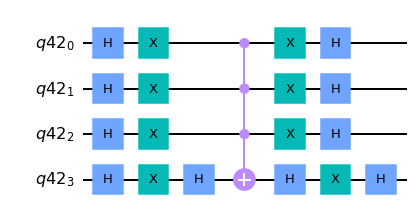

In [17]:
n=4 #search qubits
def diffusor(n):
    qr = QuantumRegister(n)
    q = QuantumCircuit(qr)
    for i in range(n):
        q.h(i)
        q.x(i)
    # q.barrier()
    q.h(n-1)
    q.mct(qr[:-1], qr[n-1])
    q.h(n-1)
    # q.barrier()
    for i in range(n):
        q.x(i)
        q.h(i)
    return q
diffusion_4 = diffusor(n).to_gate()
diffusion_4.name = '4 bit diffusion'
qr = QuantumRegister(n)
q = QuantumCircuit(qr)
q.append(diffusion_4,qr[:])
q.decompose().draw('mpl')

In [18]:
U = Operator(q)
print("4 bit diffusion operator")
display(array_to_latex(U.data))

4 bit diffusion operator


<IPython.core.display.Latex object>

In [19]:
def Grover_Gate(n, t, oracle, diffusor): #Create Grover gate
    qc = QuantumCircuit(n)
    qc.append(oracle, range(n))
    qc.append(diffusor, range(t))
    return qc
bit_len = 4 #the number of counting bits,

grit = Grover_Gate(bit_len+bit_len, bit_len, four_bit_prime_oracle, diffusor(bit_len).to_gate()).to_gate()
cgrit = grit.control()
cgrit.label = "My Grover gate"

In [20]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [21]:
qft_dagger = qft(bit_len).to_gate().inverse()
qft_dagger.label = "QFT†"

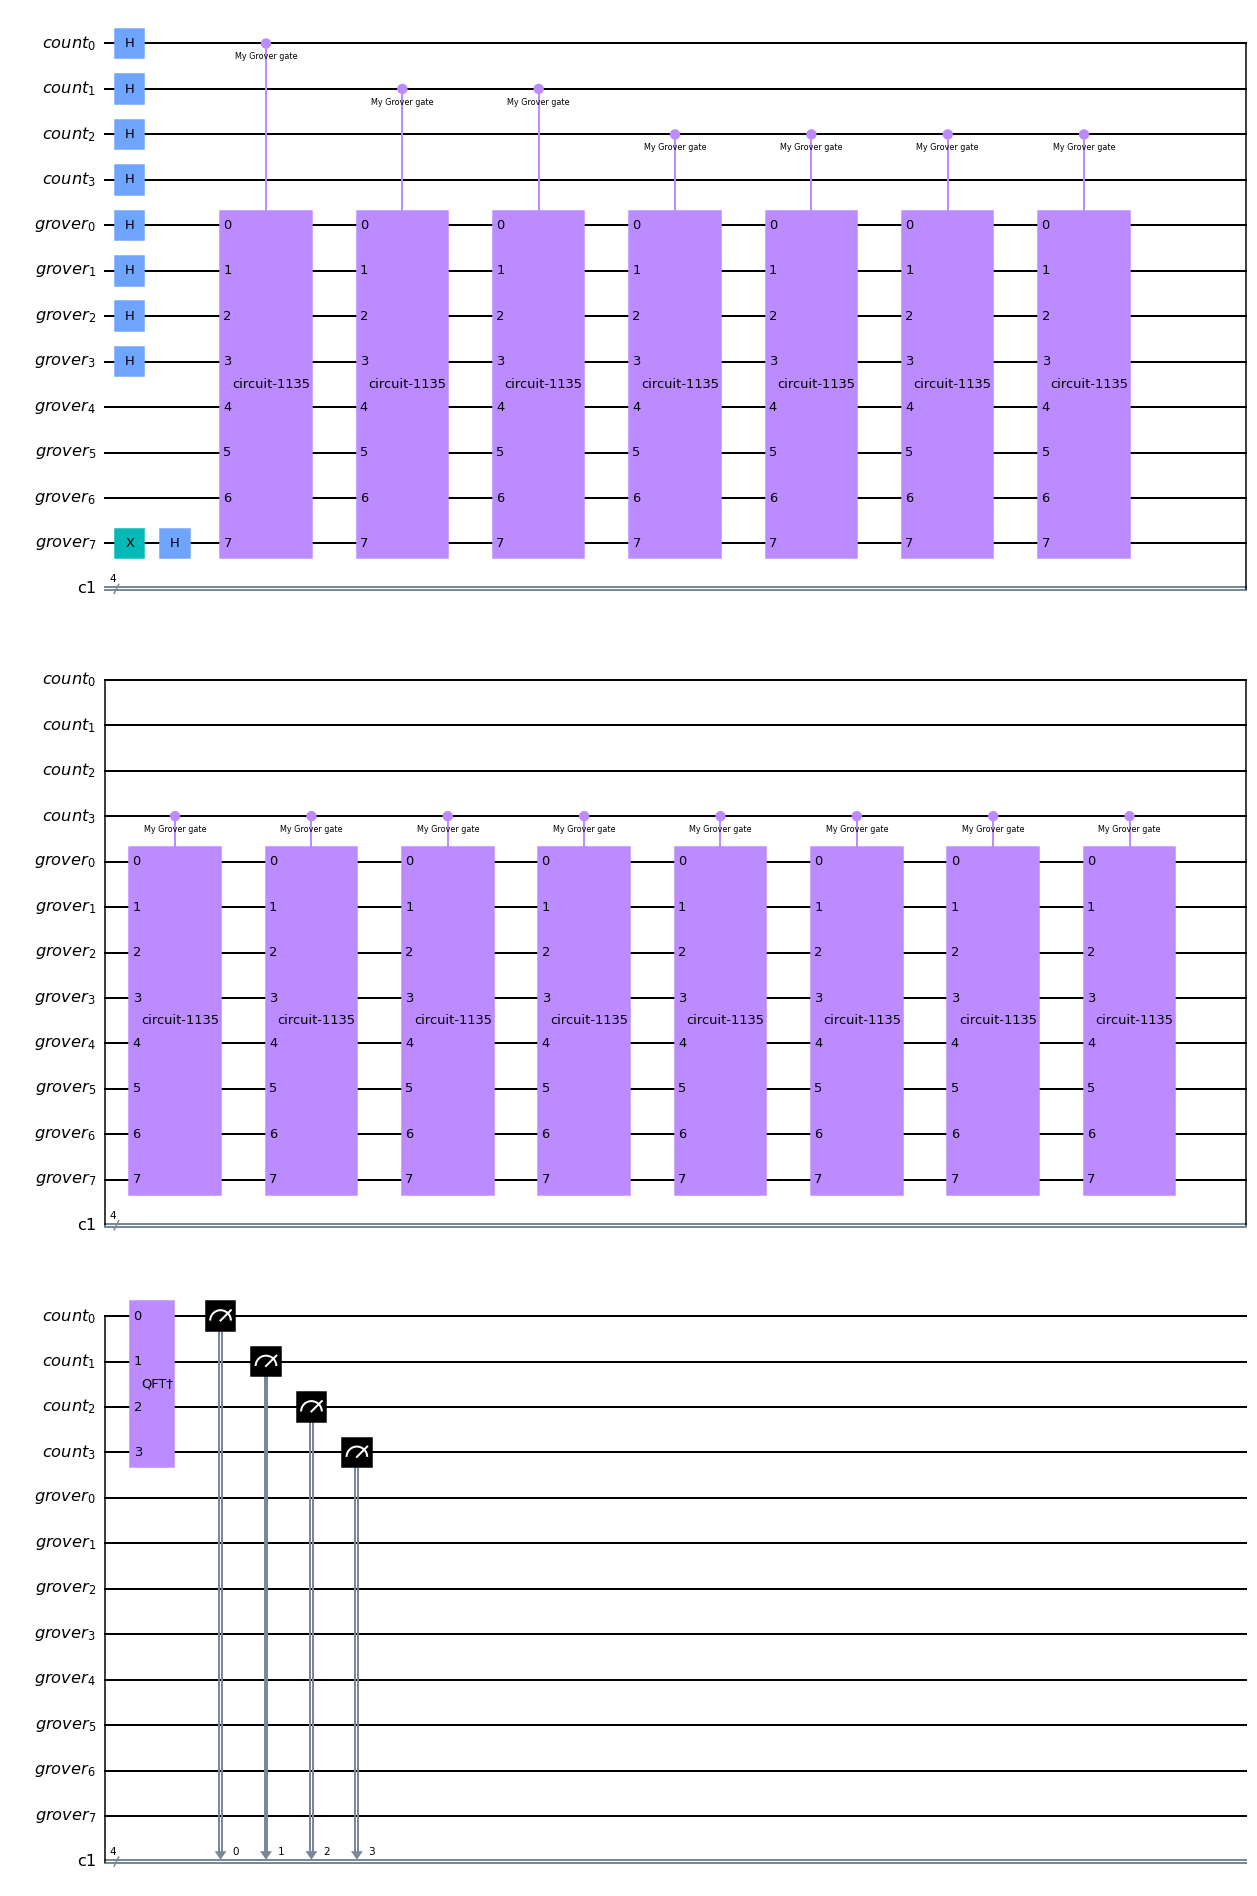

In [22]:
CoutingRegister = QuantumRegister(bit_len, 'count')
Grover_qubits = 8 #searching qubits doing the Grover algorithm part
GroverRegister = QuantumRegister(Grover_qubits, 'grover')
Classical_CountingRegister = ClassicalRegister(bit_len)
qc = QuantumCircuit(CoutingRegister, GroverRegister, Classical_CountingRegister)

for i in range(bit_len+bit_len):
    qc.h(i)
qc.x(-1)
qc.h(-1)
iterations = 1
for qubit in range(bit_len):
    for i in range(iterations):
        qc.append(cgrit, [qubit]+[*range(bit_len, bit_len+Grover_qubits)])
    iterations *= 2
    
qc.append(qft_dagger, range(bit_len))
qc.measure(range(bit_len),  range(bit_len))

qc.draw('mpl')

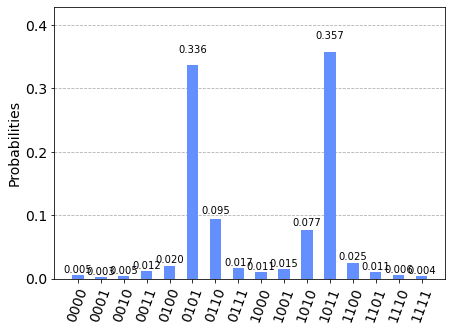

In [23]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=4096)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [31]:
measured_str = max(counts, key=counts.get)
measured_int = int(measured_str,2)
print( (measured_int+1)%(12) )
increment = counts.get(format((measured_int+1)%(2**bit_len), '04b'), -1)/counts.get(format(measured_int, '04b'), -1) 
decrement = -counts.get(format((measured_int-1)%(2**bit_len), '04b'), -1)/counts.get(format(measured_int, '04b'), -1)

measured_float = measured_int + increment + decrement 
print("Register Output = %i" % measured_float)
theta = (measured_float/(2**bit_len))*math.pi*2
print("Theta = %.5f" % theta)
N = 2**bit_len
M = N * (math.sin(theta/2)**2)
approx_solutions = round(N-M)
print("No. of Solutions = %.1f" %  approx_solutions )

0
Register Output = 10
Theta = 4.26275
No. of Solutions = 5.0


Required number of Grover iterations =  1


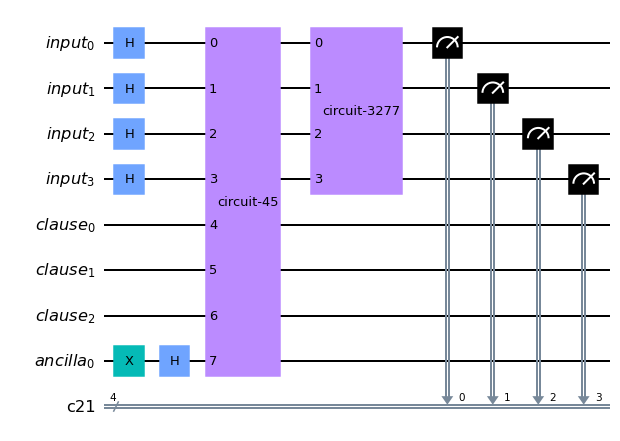

In [76]:
answer_qubits = 4
clasue_and_ancilla = 4

qr = QuantumRegister(answer_qubits+clasue_and_ancilla)
cr = ClassicalRegister(clasue_and_ancilla)
four_isPrime_Grover_circuit = QuantumCircuit(InputRegister, ClauseRegister, AncillaRegister, cr)

for i in range(answer_qubits):
    four_isPrime_Grover_circuit.h(i)

# initialize ancilla in hadamard state |->
four_isPrime_Grover_circuit.x(-1)
four_isPrime_Grover_circuit.h(-1)

#N = 2**n and M is the number of solutions
#required number of iterations is (pie/4)(sqrt(N/M))

m = approx_solutions
iterations = int( (math.pi/4) * math.sqrt((2**n/m)) )

for i in range(iterations):
    four_isPrime_Grover_circuit.append(four_bit_prime_oracle, range(answer_qubits+clasue_and_ancilla) )
    four_isPrime_Grover_circuit.append(diffusor(answer_qubits).to_gate(), range(answer_qubits))


four_isPrime_Grover_circuit.measure(range(answer_qubits), range(answer_qubits))

print("Required number of Grover iterations = ", iterations)
four_isPrime_Grover_circuit.draw()

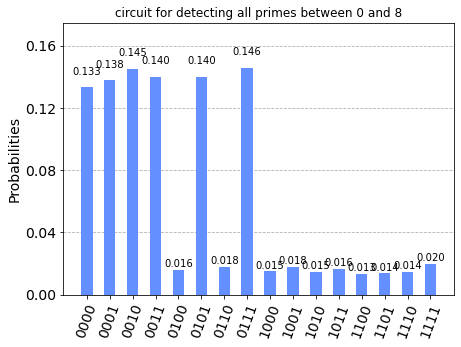

In [86]:
backend = Aer.get_backend('qasm_simulator')
shots = 4096 #max number of shots possible
job = execute(four_isPrime_Grover_circuit, backend, shots = shots)
results = job.result()
counts = results.get_counts()

plot_histogram(counts, title = 'circuit for detecting all primes between 0 and 8')

In [90]:
sort_orders = sorted(counts.items(), key=lambda x:x[1], reverse = True)

m = 1
total_percentage = 0 
for i in sort_orders:
    if(i[1] > shots/45) and int(i[0], 2) >= 2 :
        total_percentage += (i[1]/shots)*100 
        print("solution number ", m)
        print("prime = ", int(i[0], 2))
        print("Probability : ", i[1], "/", shots, " or ", (i[1]/shots)*100, " %")
        print()
        m += 1

print("Total number of solutions : ", m-1)
print("Probability of getting a right answer : ", total_percentage, "%")

solution number  1
prime =  7
Probability :  596 / 4096  or  14.55078125  %

solution number  2
prime =  2
Probability :  595 / 4096  or  14.5263671875  %

solution number  3
prime =  5
Probability :  574 / 4096  or  14.013671875  %

solution number  4
prime =  3
Probability :  574 / 4096  or  14.013671875  %

Total number of solutions :  4
Probability of getting a right answer :  57.1044921875 %


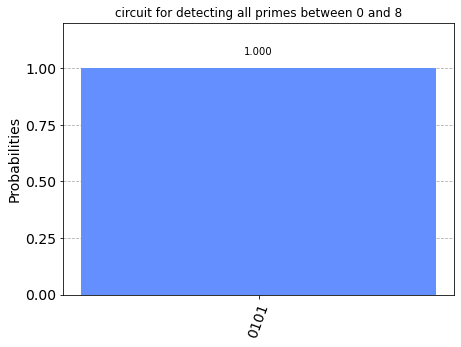

In [83]:
backend = Aer.get_backend('qasm_simulator')
shots = 1
job = execute(four_isPrime_Grover_circuit, backend, shots = shots)
results = job.result()
counts = results.get_counts()

plot_histogram(counts, title = 'circuit for detecting all primes between 0 and 8')

In [84]:
i = list(counts)

print("solution ")
print("prime = ", int(i[0], 2))
print()

solution 
prime =  5



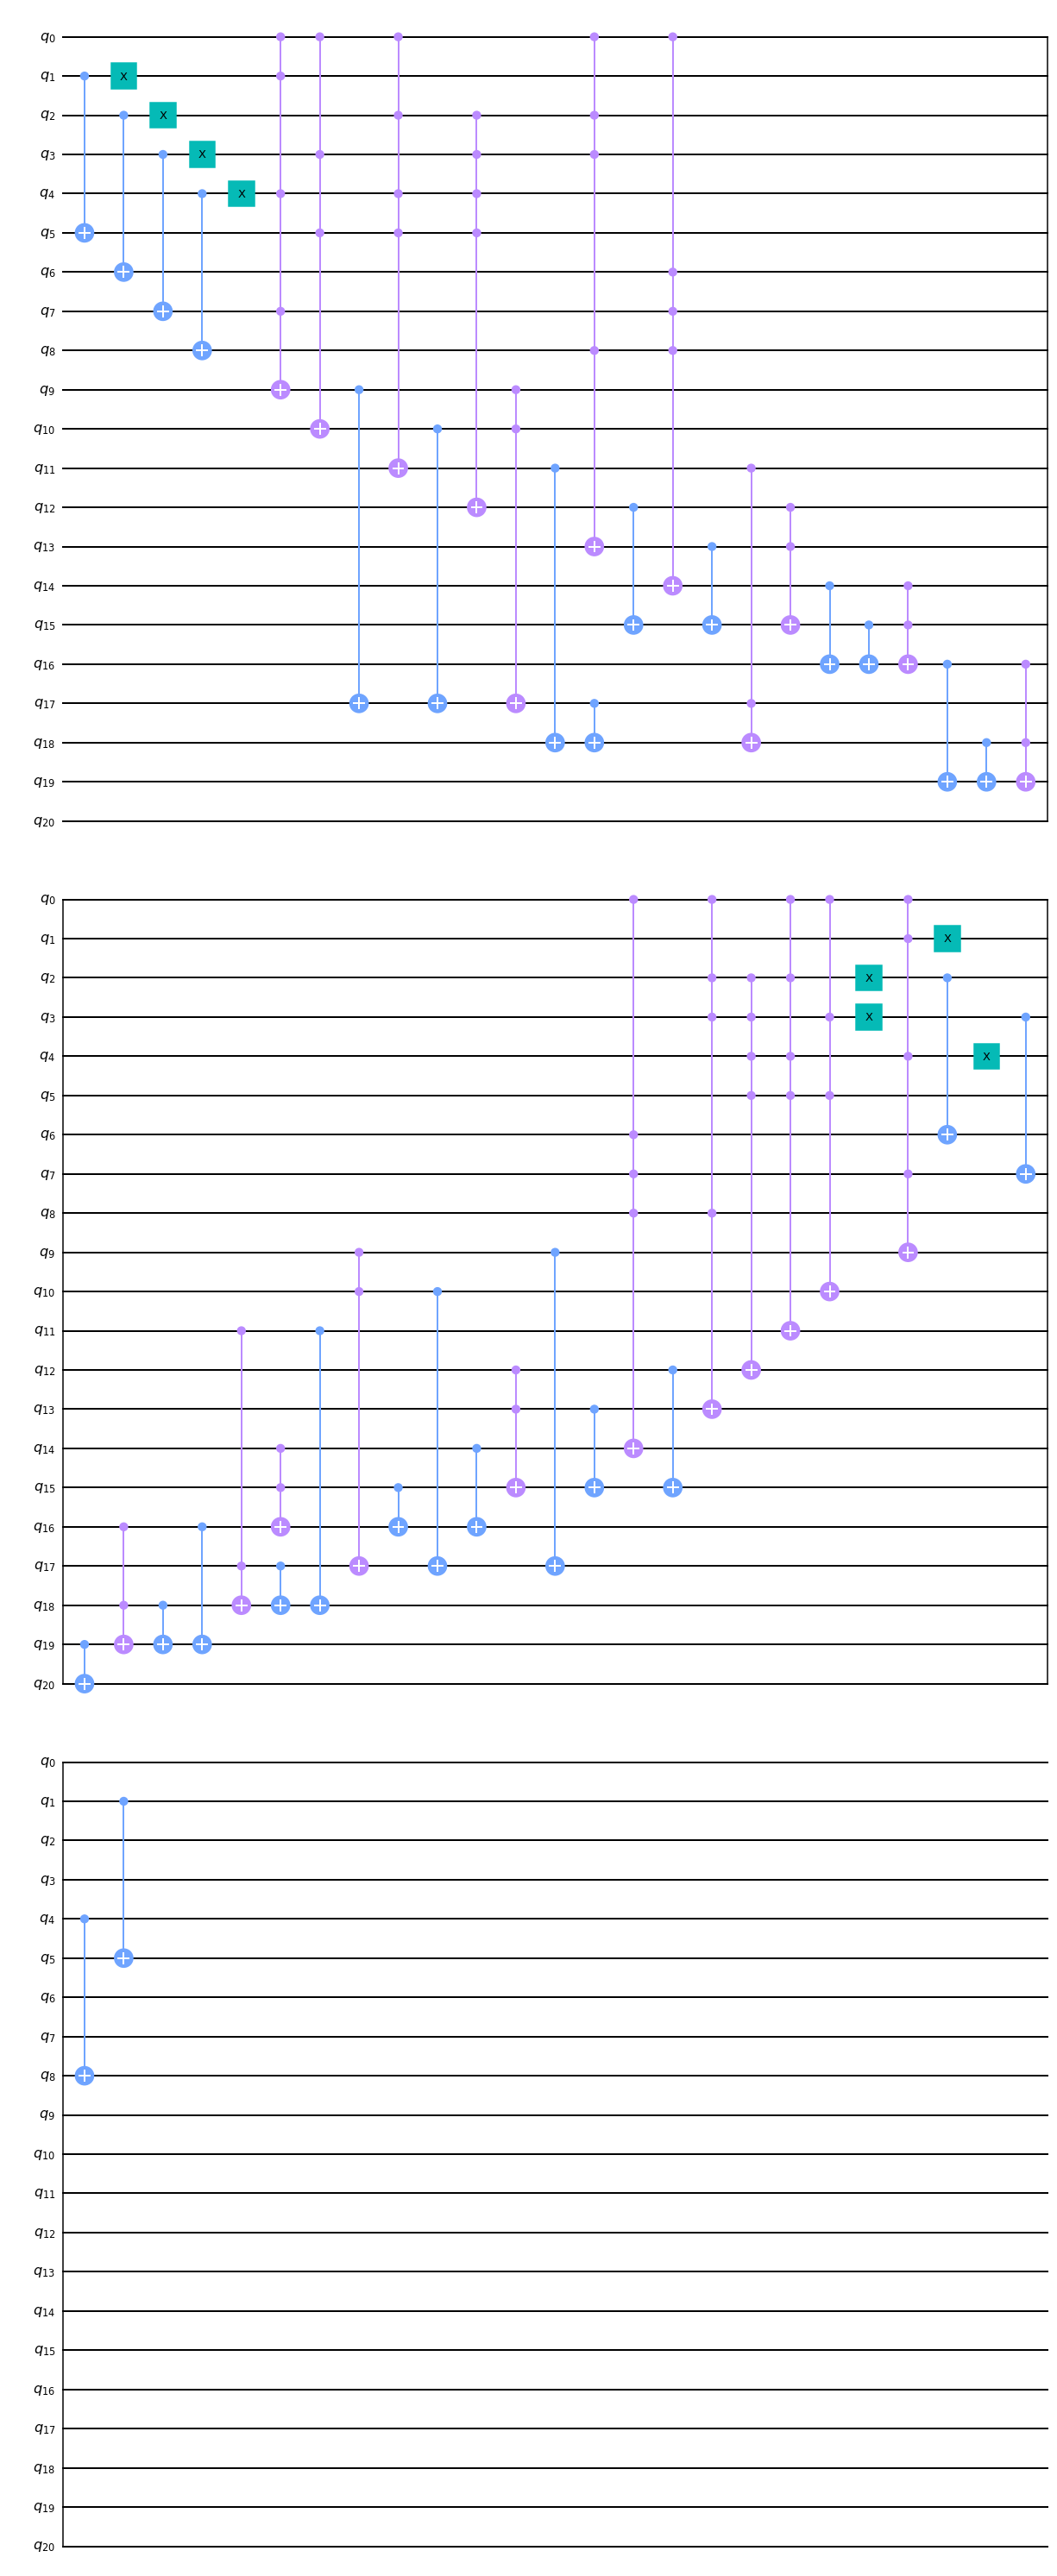

In [91]:
q = QuantumCircuit(21)

# q.barrier()
for i in range(1,5,1):
    q.cx(i,i+4)
# q.barrier()
for i in range(1,5,1):
    q.x(i)


q.mct([0, 1, 4, 7], 9)
q.mct([0, 3, 5], 10)
q.mct([0, 2, 4, 5], 11)
q.mct([2, 3, 4, 5], 12)
q.mct([0, 2, 3, 8], 13)
q.mct([0, 6, 7, 8], 14)

# q.barrier()
q.cx(12, 15)
q.cx(13, 15)
q.mct([12, 13], 15)
# q.barrier()
q.cx(14, 16)
q.cx(15, 16)
q.mct([14, 15], 16)

# q.barrier()

q.cx(9, 17)
q.cx(10, 17)
q.mct([9, 10], 17)
# q.barrier()
q.cx(11, 18)
q.cx(17, 18)
q.mct([11, 17], 18)
# q.barrier()
q.cx(16, 19)
q.cx(18, 19)
q.mct([16, 18], 19)
# q.barrier()

q.cx(19, 20)

# # q.barrier()
q.mct([16, 18], 19)
q.cx(18, 19)
q.cx(16, 19)
# q.barrier()
q.mct([11, 17], 18)
q.cx(17, 18)
q.cx(11, 18)
# q.barrier()
q.mct([9, 10], 17)
q.cx(10, 17)
q.cx(9, 17)

# # q.barrier()

q.mct([14, 15], 16)
q.cx(15, 16)
q.cx(14, 16)
# q.barrier()
q.mct([12, 13], 15)
q.cx(13, 15)
q.cx(12, 15)
# q.barrier()

q.mct([0, 6, 7, 8], 14)
q.mct([0, 2, 3, 8], 13)
q.mct([2, 3, 4, 5], 12)
q.mct([0, 2, 4, 5], 11)
q.mct([0, 3, 5], 10)
q.mct([0, 1, 4, 7], 9)

# # q.barrier()
for i in range(1,5,1):
    q.x(i)
# # q.barrier()
for i in range(4,0,-1):
    q.cx(i,i+4)
five_bit_prime_detector = q.to_gate()



q.draw(output='mpl')#scale=0.5

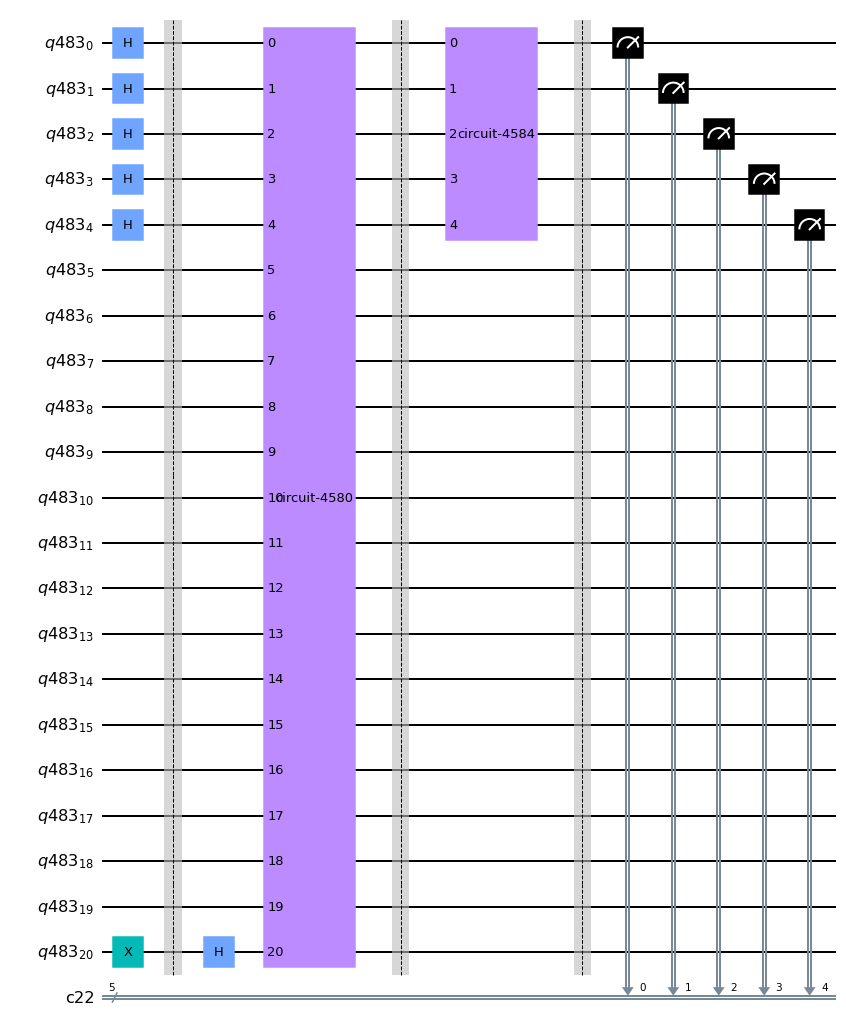

In [92]:
n = 5
qr = QuantumRegister(21)
cr = ClassicalRegister(5)
q = QuantumCircuit(qr, cr)

q.x(-1)
for i in range(n):
    q.h(i)

q.barrier()
q.h(-1)
q.append(five_bit_prime_detector, qr[:])
# q.h(-1)
q.barrier()

diffusion_5 = diffusor(5).to_gate()
q.append(diffusion_5,[0,1,2,3,4])
q.barrier()



for i in range(n):
    q.measure(i,i)
    
q.draw(output='mpl')#, plot_barriers=False, reverse_bits=True

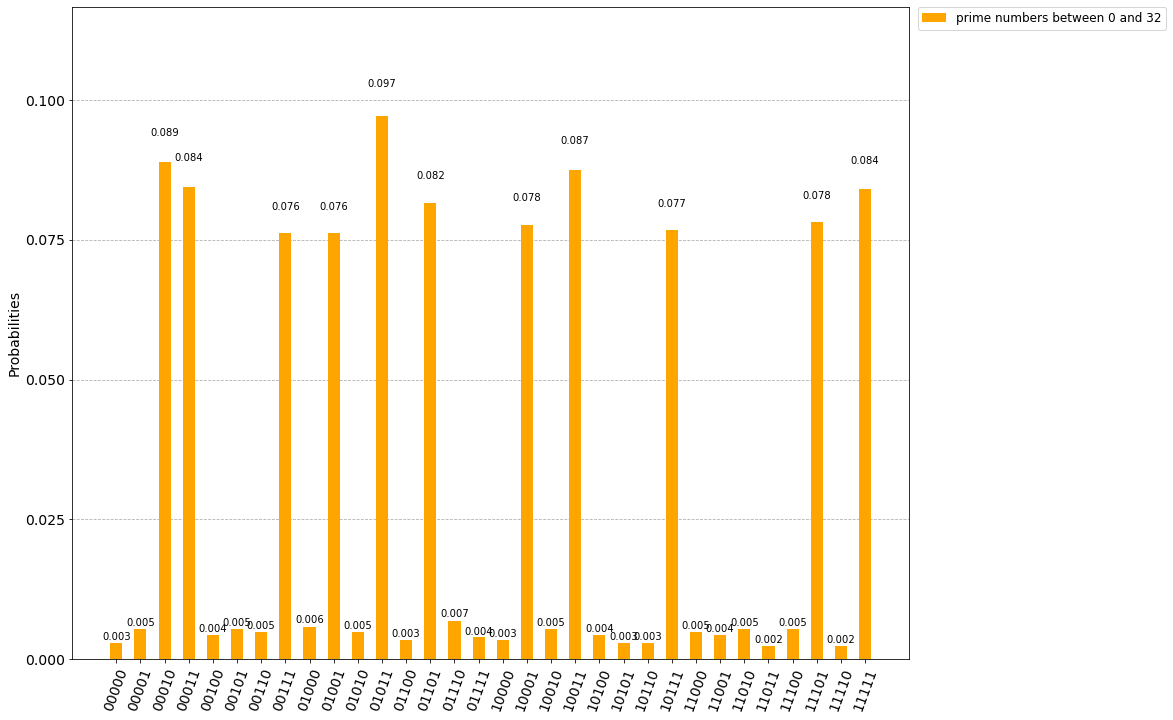

In [93]:
backend = Aer.get_backend('qasm_simulator')
shots = 2048
job = execute(q, QasmSimulator(), shots=2048)
result = job.result()
counts = result.get_counts()
legend = ['prime numbers between 0 and 32']
plot_histogram(counts, legend = legend, figsize=(15, 12), color='orange')

In [94]:
sort_orders = sorted(counts.items(), key=lambda x:x[1], reverse = True)

m = 1
total_percentage = 0 
for i in sort_orders:
    if(i[1] > shots/45) and int(i[0], 2) >= 2 :
        total_percentage += (i[1]/shots)*100 
        print("solution number ", m)
        print("prime = ", int(i[0], 2))
        print("Probability : ", i[1], "/", shots, " or ", (i[1]/shots)*100, " %")
        print()
        m += 1

print("Total number of solutions : ", m-1)
print("Probability of getting a right answer : ", total_percentage, "%")

solution number  1
prime =  11
Probability :  199 / 2048  or  9.716796875  %

solution number  2
prime =  2
Probability :  182 / 2048  or  8.88671875  %

solution number  3
prime =  19
Probability :  179 / 2048  or  8.740234375  %

solution number  4
prime =  3
Probability :  173 / 2048  or  8.447265625  %

solution number  5
prime =  31
Probability :  172 / 2048  or  8.3984375  %

solution number  6
prime =  13
Probability :  167 / 2048  or  8.154296875  %

solution number  7
prime =  29
Probability :  160 / 2048  or  7.8125  %

solution number  8
prime =  17
Probability :  159 / 2048  or  7.763671875  %

solution number  9
prime =  23
Probability :  157 / 2048  or  7.666015625  %

solution number  10
prime =  7
Probability :  156 / 2048  or  7.6171875  %

solution number  11
prime =  9
Probability :  156 / 2048  or  7.6171875  %

Total number of solutions :  11
Probability of getting a right answer :  90.8203125 %


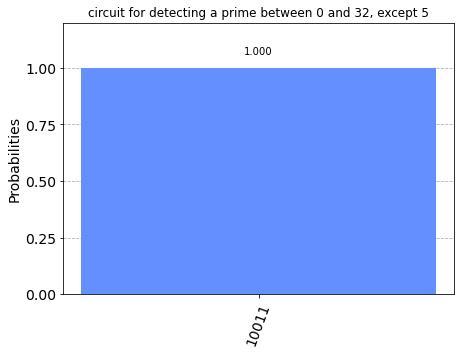

In [96]:
backend = Aer.get_backend('qasm_simulator')
shots = 1
job = execute(q, backend, shots = shots)
results = job.result()
counts = results.get_counts()

plot_histogram(counts, title = 'circuit for detecting a prime between 0 and 32, except 5')

In [97]:
i = list(counts)

print("solution ")
print("prime = ", int(i[0], 2))
print()

solution 
prime =  19



In [98]:
t = 4 #counting qubits doing Quantum counting algo part
n = 21 #searching qubits doing the Grover algorithm part

In [99]:
Grover = Grover_Gate(n, 5, five_bit_prime_detector, diffusion_5).to_gate()
ctr_Grover = Grover.control()
qft_dagger = qft(t).to_gate().inverse()
qft_dagger.label = "QFT†"

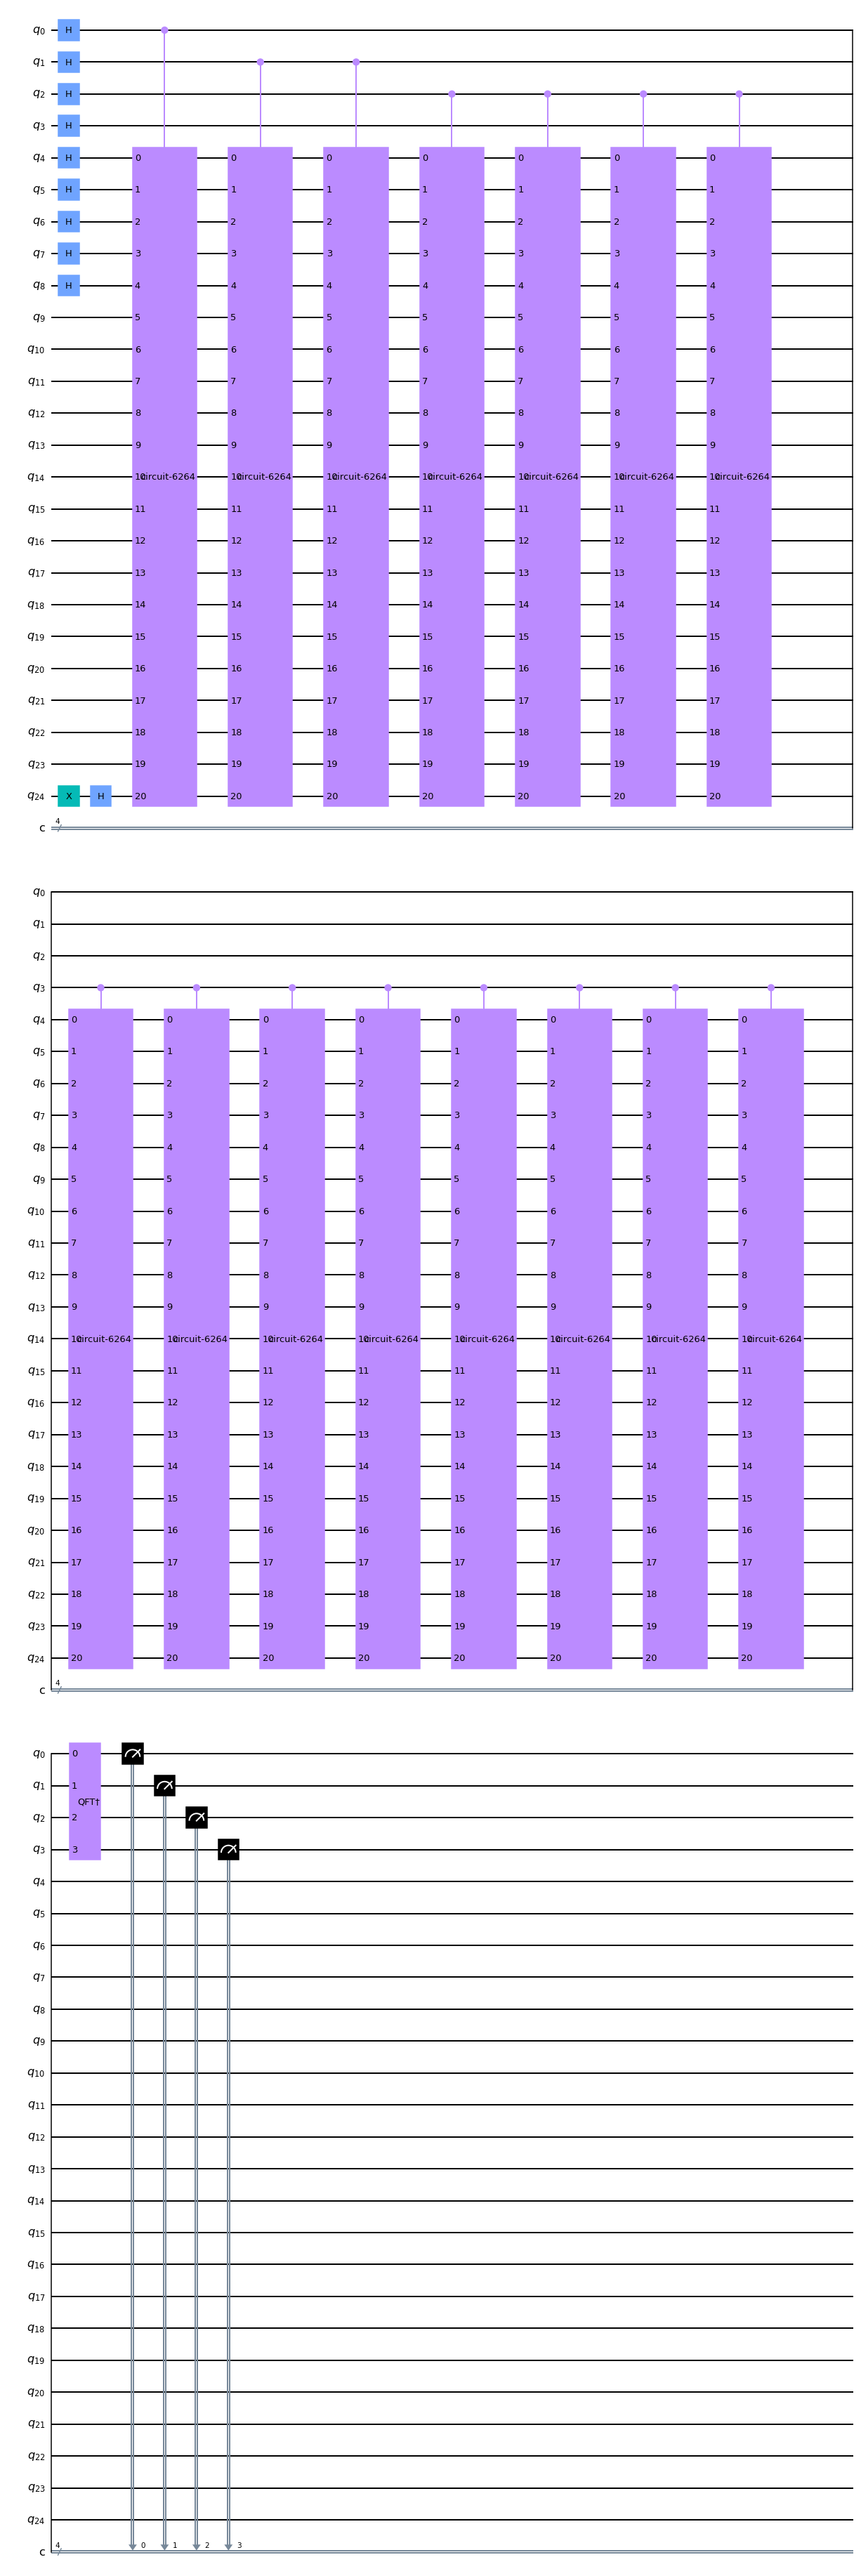

In [100]:
#search_bits for Grover 
m = 5

qc = QuantumCircuit(n+t, t)

for i in range(t+m):
    qc.h(i)
qc.x(-1)
qc.h(-1)
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(ctr_Grover, [qubit]+[*range(t, n+t)])
    iterations *= 2
    
qc.append(qft_dagger, range(t))
qc.measure(range(t),  range(t))

qc.draw()

In [101]:
print("Quantum counting for 5 bit prime depth: ", qc.depth())

Quantum counting for 5 bit prime depth:  19


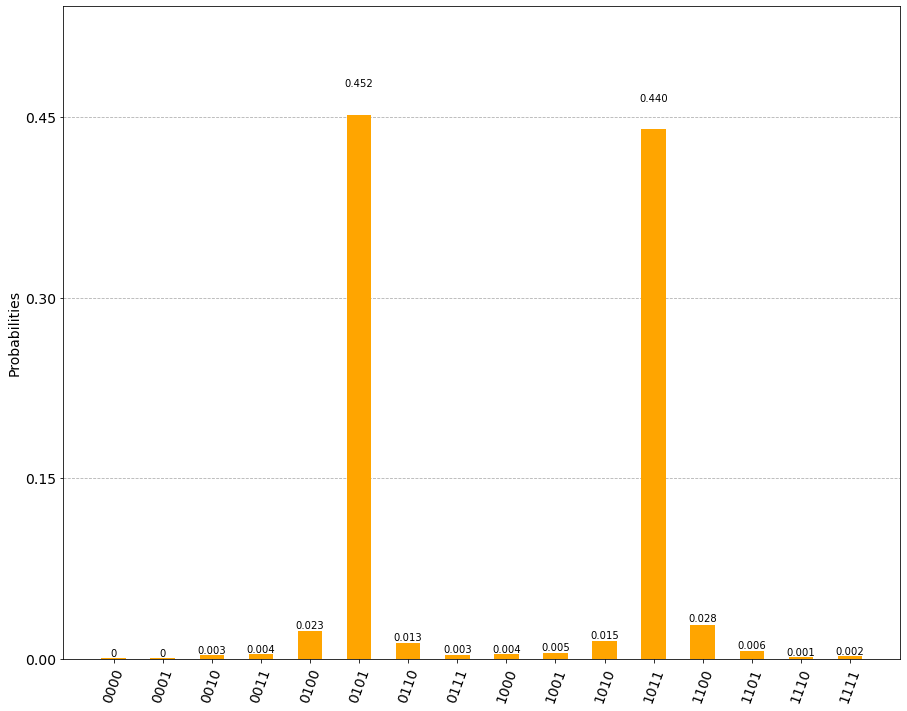

In [102]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=2048)
result = job.result()
counts = result.get_counts()

plot_histogram(counts, figsize=(15, 12), color='orange')

In [103]:
measured_str = max(counts, key=counts.get)
measured_int = int(measured_str, 2)
increment = counts.get(format((measured_int+1)%2**t, '04b'), -1)/counts.get(format(measured_int, '04b'), -1) 
decrement = -counts.get(format((measured_int-1)%2**t, '04b'), -1)/counts.get(format(measured_int, '04b'), -1)
measured_float = measured_int + increment + decrement 

theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)
N = 2**t
M = N * (math.sin(theta/2)*2)
print("Number of solutions = %.1f" % (round(abs(N-M)) ) )

Theta = 1.96350
Number of solutions = 11.0
